# Actividad práctica: Predicción de series de tiempo

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

- Siga las instrucciones en este notebook para resolver el problema de predicción
- Conteste las preguntas que se encuentran en este enunciado
- Finalmente envíe su notebook con los resultados y respuestas a phuijse@inf.uach.cl
- No olvide cambiar el título para reflejar los integrantes de su grupo

In [1]:
import numpy as np

%matplotlib notebook
from IPython.display import display, Audio, HTML
import matplotlib.pylab as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import scipy.signal
%matplotlib notebook
from matplotlib import animation, patches
import soundfile as sf
from style import *

import pandas as pd
from pandas import *

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

17.0


<IPython.core.display.Javascript object>


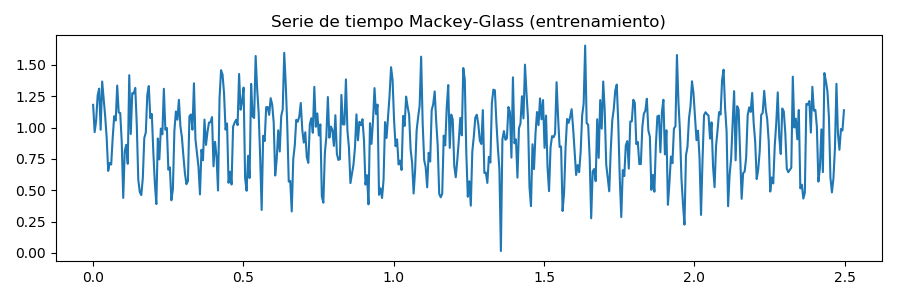

In [3]:

# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 17.
print(tau)
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');
    


***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener 
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
1. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la línea que dice 

` self.w = ? `

con el valor correcto de actualización de peso del filtro LMS

In [4]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):
        d_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        self.w = self.w + 2 * self.mu * (d - d_pred) * u / norm

***
## Predicción con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logarítmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente caótico) 
1. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué casos son más sencillos y cuales más complicados?


In [5]:
data_NMSE_train = []
data_NMSE_test = []
L = [5,10,20,30]
mu = np.logspace(-2,0,num=20)

In [6]:
def lms_update(L,mu,print_plot):
    lms = LMS_filter(L, mu, normalized=True)

    # Entrenamiento
    y_pred = np.zeros(shape=(len(y_obs), ))
    for k in range(lms.__len__(), 500):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)
        lms.update(d=y_obs[k], u=y_window)
    # Prueba
    for k in range(500, len(y_obs)):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)
    #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
     #                                           NMSE(ymg[500:], y_pred[500:])))
    
    data_NMSE_train.append((NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500])))
    data_NMSE_test.append(NMSE(ymg[500:], y_pred[500:]))
                           
    if print_plot:
        print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))
    
        fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
        ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
        ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
        ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
        ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

        ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
        ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend();

In [7]:
L = [5,10,20,30]
mu = np.logspace(-2,0,num=20)

l_opt = mu_opt = test_opt = 100000000

for l_val in L:
    print("L = %i"%l_val)
    data_NMSE_train = []
    data_NMSE_test = []
    for mu_val in mu:
        lms_update(l_val,mu_val,print_plot=False)
    df = DataFrame({"MU":mu, "MSE TRAIN": data_NMSE_train,"MSE TEST": data_NMSE_test})
    print(df)
    
    for opt in data_NMSE_test:
        if opt < test_opt:
            test_opt = opt
            l_opt = l_val
            mu_opt = mu[data_NMSE_test.index(opt)]
    
    if l_val < 30 : print("--------------------------------------------------------------------------")
    
print("\n Valores Optimos L = %i, mu = %f, test = %f"%(l_opt,mu_opt,test_opt))

L = 5
          MU      MSE TRAIN      MSE TEST
0   0.010000    1227.875391    772.859405
1   0.012743    1136.920362    737.473806
2   0.016238    1058.872798    699.637279
3   0.020691     990.578039    660.837201
4   0.026367     930.763455    622.758244
5   0.033598     879.281332    587.180397
6   0.042813     836.287966    555.906458
7   0.054556     801.895461    530.890604
8   0.069519     776.418603    514.488722
9   0.088587     760.872241    509.466977
10  0.112884     757.278881    518.471730
11  0.143845     768.607048    543.273189
12  0.183298     798.571314    584.660489
13  0.233572     851.908173    645.379641
14  0.297635     936.243278    748.348290
15  0.379269    1068.216727   1006.644944
16  0.483293    1291.635428   1772.736146
17  0.615848    1738.864635   3777.327184
18  0.784760    3023.395867   8874.572654
19  1.000000  123371.808378  94442.718775
--------------------------------------------------------------------------
L = 10
          MU     MSE TRAIN    

In [8]:
def lms_slider(L,mu):
    lms_update(L,mu,print_plot=True)
    
interact(lms_slider, L=widgets.SelectionSlider(options=L, value=l_opt),mu=np.logspace(-2,0,num=20))

interactive(children=(SelectionSlider(description='L', index=3, options=(5, 10, 20, 30), value=30), Dropdown(d…

<function __main__.lms_slider(L, mu)>

30.0


<IPython.core.display.Javascript object>


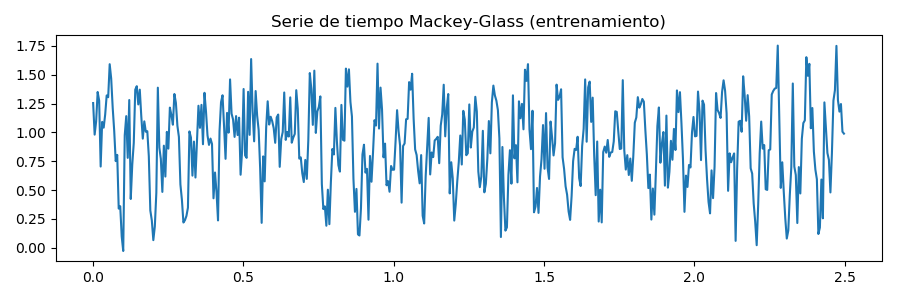

In [11]:

# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 30.
print(tau)
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

In [12]:
test_opt = 100000000

for l_val in L:
    print("L = %i"%l_val)
    data_NMSE_train = []
    data_NMSE_test = []
    for mu_val in mu:
        lms_update(l_val,mu_val,print_plot=False)
    df = DataFrame({"MU":mu, "MSE TRAIN": data_NMSE_train,"MSE TEST": data_NMSE_test})
    print(df)
    
    for opt in data_NMSE_test:
        if opt < test_opt:
            test_opt = opt
            l_opt = l_val
            mu_opt = mu[data_NMSE_test.index(opt)]
    
    if l_val < 30 : print("--------------------------------------------------------------------------")
    
print("\n Valores Optimos L = %i, mu = %f, test = %f"%(l_opt,mu_opt,test_opt))

L = 5
          MU      MSE TRAIN       MSE TEST
0   0.010000     757.438945     484.937709
1   0.012743     703.711347     468.751682
2   0.016238     657.686966     451.333702
3   0.020691     617.535840     433.044089
4   0.026367     582.719060     414.372074
5   0.033598     553.516097     396.206732
6   0.042813     530.495121     379.896389
7   0.054556     514.218674     367.069998
8   0.069519     505.222932     359.426844
9   0.088587     504.122342     359.182371
10  0.112884     511.802804     371.129315
11  0.143845     529.944022     406.841344
12  0.183298     562.114352     490.537855
13  0.233572     615.426024     666.628826
14  0.297635     703.386561    1012.345948
15  0.379269     853.558416    1656.061172
16  0.483293    1132.264637    2787.574026
17  0.615848    1745.624303    4736.445823
18  0.784760    3793.709929   11101.463509
19  1.000000  196930.621407  446613.865841
--------------------------------------------------------------------------
L = 10
         

***
## Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS
1. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 
1. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = ?`

con el valor correcto de actualización de peso del filtro RLS

In [61]:
class RLS_filter(object):
    
    def __init__(self, L=1, beta=0.9, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T)
        k = invbeta*np.dot(self.Phi_inv, u)/r
        self.Phi_inv = invbeta* self.Phi_inv - invbeta * self.Phi_inv *np.sum(k*u)
        self.w = self.w + np.dot(k,e)
       
        

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
1. Repita el experimento para $\tau=30$
1. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?


In [64]:

rls = RLS_filter(L=30, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 265.0973, prueba 210.8025


<IPython.core.display.Javascript object>


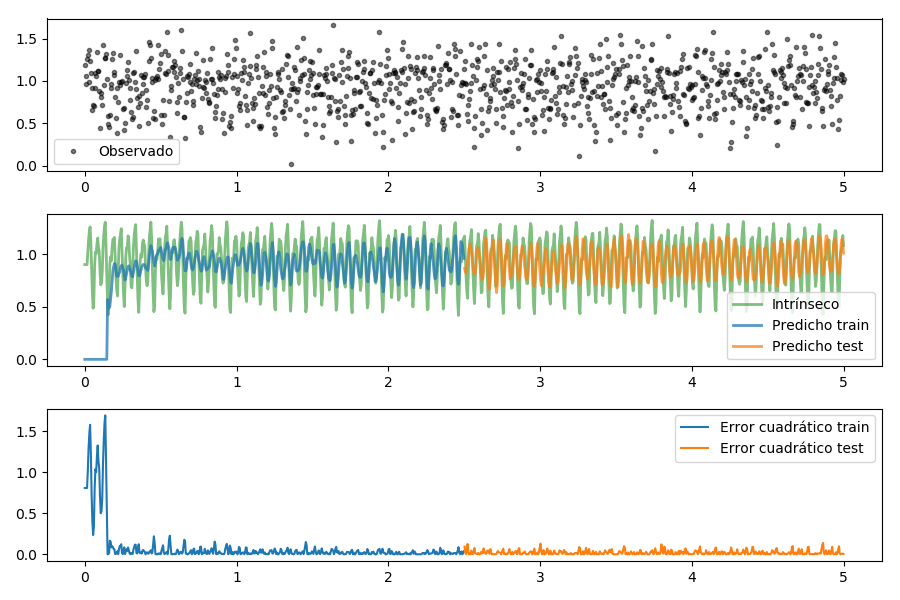

In [12]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

<IPython.core.display.Javascript object>


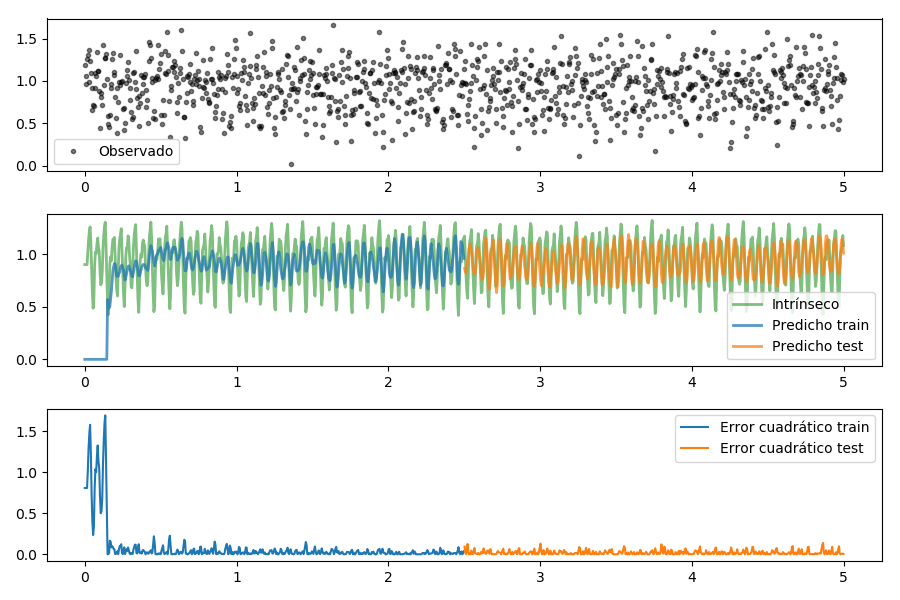

In [63]:
print_plot()